# HDDA F24 Recommendation systems via approximate matrix factorization

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 1


In [ ]:
import copy
import math
from typing import Callable, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import torch
import tqdm
from scipy.sparse import csr_matrix
from sklearn.impute import SimpleImputer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities


In [ ]:
def get_params_combinations(params: list[list]):
    if len(params) == 0:
        return [[]]
    return [(x, *k) for k in get_params_combinations(params[1:]) for x in params[0]]


def get_params_combinations_dict(
    possible_params_dict: dict[str, list]
) -> list[tuple[dict, str]]:
    if len(possible_params_dict) == 0:
        return [({}, "")]
    dict_items = list(possible_params_dict.items())

    first_item = dict_items[0]

    if not isinstance(first_item[1], list):
        return [
            ({first_item[0]: first_item[1], **k}, name)
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        ]

    if (
        len(first_item[1]) > 0
        and isinstance(first_item[1][0], tuple)
        and isinstance(first_item[1][0][0], str)
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x_name}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x_name, x in first_item[1]
        ]

    if (
        len(first_item[1]) > 0 and str(first_item[1][0]) != "<"  # has ___str__
    ):
        return [
            (
                {first_item[0]: x, **k},
                f"{first_item[0]}=[{x!s}]{', ' + name if len(name) > 0 else ''}",
            )
            for k, name in get_params_combinations_dict(dict(dict_items[1:]))
            for x in first_item[1]
        ]

    return [
        (
            {first_item[0]: x, **k},
            f"{first_item[0]}=[{x}]{', ' + name if len(name) > 0 else ''}",
        )
        for k, name in get_params_combinations_dict(dict(dict_items[1:]))
        for x in first_item[1]
    ]

In [ ]:
def rmse_score(
    initial_matrix: torch.Tensor, predicted_matrix: torch.Tensor, test_mask: torch.Tensor
) -> float:
    differences = (initial_matrix[test_mask] - predicted_matrix[test_mask]) ** 2
    return torch.sqrt(differences.mean()).item()

In [ ]:
def choose_best(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    solver: Callable,
    possible_params: dict,
    loss_param: str = "rmse_test",
) -> tuple[torch.Tensor, float, dict, dict]:
    best_loss = 1e3
    best_solution = torch.zeros(1)
    best_params = {}

    log_dicts = {}

    for params, name in get_params_combinations_dict(possible_params):
        solution, log_dict = solver(matrix, mask, test_mask, **params)
        log_dicts[name] = log_dict

        loss = log_dict[loss_param][-1]

        if loss < best_loss:
            best_loss = loss
            best_solution = solution.clone()
            best_params = params.copy()

    return best_solution, best_loss, best_params, log_dicts

In [ ]:
def plot_log_dicts(
    log_dicts: dict,
    title: str,
    row_plots: int = 2,
    plot_width: float = 8,
    plot_height: float = 4,
):
    num_plots = 4
    row_plots = min(row_plots, num_plots)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )
    axs_list = list(axs.flat)

    for ax in axs_list:
        ax.grid()

    axs_list[0].set(xlabel="Iteration", ylabel="Objective, log")
    axs_list[1].set(xlabel="Iteration", ylabel="RMSE, log")
    axs_list[2].set(xlabel="Iteration", ylabel="Objective on test, log")
    axs_list[3].set(xlabel="Iteration", ylabel="RMSE on test, log")

    axs_list[0].set_title("Results on train data")
    axs_list[1].set_title("Results on train data")
    axs_list[2].set_title("Results on test data")
    axs_list[3].set_title("Results on test data")

    for ax in axs_list:
        ax.set_yscale("log")

    for name, log_dict in log_dicts.items():
        axs_list[0].plot(log_dict["iteration"], log_dict["objective"], label=name)
        axs_list[1].plot(log_dict["iteration"], log_dict["rmse"], label=name)
        axs_list[2].plot(log_dict["iteration"], log_dict["objective_test"], label=name)
        axs_list[3].plot(log_dict["iteration"], log_dict["rmse_test"], label=name)

    fig.suptitle(title, fontsize=14)

    lines_labels = [axs_list[0].get_legend_handles_labels()]
    lines, labels = [sum(x, []) for x in zip(*lines_labels)]

    fig.legend(
        lines,
        labels,
        loc="outside lower center",
        ncol=min(5, len(log_dicts)),
        bbox_to_anchor=(0.5, -0.05 * (math.ceil(len(log_dicts) / 5) + 1)),
    )

    plt.tight_layout(w_pad=5)
    plt.show()

In [ ]:
def train_test_split_matrix(
    matrix: np.ndarray, mask: np.ndarray, test_percent: float, seed=420
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    np.random.seed(seed)

    train_matrix = matrix.copy().flatten()
    train_mask = mask.copy().flatten()
    test_mask = np.zeros(mask.shape).astype(bool).flatten()

    existing_indices = np.argsort(~train_mask)[: np.sum(train_mask)]
    test_indices = np.random.choice(
        existing_indices, int(existing_indices.shape[0] * test_percent), replace=False
    )

    train_matrix[test_indices] = 0.0
    train_mask[test_indices] = False
    test_mask[test_indices] = True

    matrix_shape = matrix.shape

    return torch.tensor(train_matrix.reshape(matrix_shape)).float().to(
        DEVICE
    ), torch.tensor(train_mask.reshape(matrix_shape)).bool().to(DEVICE), torch.tensor(
        test_mask.reshape(matrix_shape)
    ).bool().to(DEVICE), torch.tensor(matrix).float().to(DEVICE), torch.tensor(
        mask
    ).bool().to(DEVICE)

## Data loading


### Toy data


In [ ]:
toy_matrix_full = np.array(
    [
        [2, 3, 2, 0, 0],
        [0, 2, 0, 4, 3],
        [3, 0, 3, 0, 4],
        [0, 3, 0, 4, 3],
        [0, 0, 0, 0, 2],
        [1, 4, 3, 4, 0],
    ]
)

toy_mask_full = toy_matrix_full != 0

In [ ]:
(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    toy_matrix_full,
    toy_mask_full,
) = train_test_split_matrix(toy_matrix_full, toy_mask_full, test_percent=0.2)

### Real data


In [ ]:
def load_real_data() -> tuple[np.ndarray, np.ndarray]:
    data = scipy.io.loadmat("./data/Data/matlab/inputX.mat")
    x = csr_matrix(data["X"]).toarray()
    mask = x != 0
    return x, mask


real_matrix_full, real_mask_full = load_real_data()

In [ ]:
(
    real_matrix,
    real_mask,
    real_test_mask,
    real_matrix_full,
    real_mask_full,
) = train_test_split_matrix(real_matrix_full, real_mask_full, test_percent=0.2)

print(f"Test size: {int(real_test_mask.sum())}")

Test size: 160033


## Test real data


In [ ]:
def load_real_test_flatten_indices(real_matrix_shape: tuple) -> torch.Tensor:
    data = scipy.io.loadmat("./data/Data/matlab/inputEval.mat")
    x = data["Eval"]
    rows_indices = x[:, 0].astype(np.float64) - 1
    columns_indices = x[:, 1].astype(np.float64) - 1
    return (
        torch.tensor(rows_indices * real_matrix_shape[1] + columns_indices)
        .int()
        .to(DEVICE)
    )


real_test_flatten_indices = load_real_test_flatten_indices(real_matrix.shape)
real_test_flatten_indices

tensor([     593,     3104,     1544,  ..., 23868889, 23868137, 23868149],
       device='cuda:0', dtype=torch.int32)

In [ ]:
def save_solution(
    matrix: torch.Tensor,
    test_flatten_indices: torch.Tensor = real_test_flatten_indices,
    prefix: str = "",
    decimals: int = 4,
):
    predictions = np.round(
        matrix.flatten()[test_flatten_indices].cpu().numpy(), decimals=decimals
    )
    results = pd.DataFrame(
        predictions, columns=["Rating"], index=np.arange(1, predictions.shape[0] + 1)
    )
    results.to_csv(f"./solutions/{prefix}submission.csv", index_label="ID")

## Block coordinate descent


### LR strategies


In [ ]:
class LearningRateScheduler:
    @staticmethod
    def _vector_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.dot(x, y)

    @staticmethod
    def _matrix_dot(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.trace(x.T @ y)

    def __init__(self, assume_vectors: bool = False) -> None:
        self.assume_vectors = assume_vectors
        self.dot = (
            LearningRateScheduler._vector_dot
            if self.assume_vectors
            else LearningRateScheduler._matrix_dot
        )

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        raise NotImplementedError


class Normal(LearningRateScheduler):
    def __init__(
        self,
        lr: Callable[[int], float] | float = 1e-3,
        name: str = "",
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.name = name
        self.lr = lr
        self.lr_func: Callable[[int], float] = (
            (lambda _: lr) if isinstance(lr, float) else lr
        )  # type: ignore

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        return self.lr_func(k)

    def __str__(self) -> str:
        return (
            self.name
            if self.name
            else (str(self.lr) if isinstance(self.lr, float) else "normal")
        )


class Estimate1OverL(LearningRateScheduler):
    def __init__(
        self,
        beta: float = 0.25,
        max_iters: int = 100,
        eps: float = 1e-7,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.beta = beta
        self.max_iters = max_iters
        self.eps = eps

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = 1

        i = 0
        while True:
            x_next = x + alpha * direction
            if f(x_next) > self.eps + f(x) + self.dot(grad, (x_next - x)) + torch.norm(
                x_next - x
            ) ** 2 / (2 * alpha):
                i += 1
                alpha *= self.beta
                if alpha < 1e-10:
                    return alpha

            else:
                return alpha

            if i >= self.max_iters:
                return alpha

    def __str__(self) -> str:
        return "1/L"


class AdaptiveStep(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1e-6,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.theta = np.inf
        self.prev_step = None

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        if self.prev_step is None:
            step = self.start_step
            self.theta = np.inf
            self.prev_step = step
            return step

        step = self.prev_step
        if torch.norm(prev_grad - grad) < 1e-5:
            min_value = np.sqrt(1 + self.theta) * step
        else:
            min_value = min(
                np.sqrt(1 + self.theta) * step,
                float(
                    (torch.norm(x - prev_x) / (2 * torch.norm(prev_grad - grad)))
                    .cpu()
                    .numpy(),
                ),
            )
        if min_value == np.inf:
            min_value = 0.001

        self.theta = min_value / step
        step = min_value
        self.prev_step = step

        return step

    def __str__(self) -> str:
        return "adaptive"


class Armijo(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-6,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.beta = beta
        self.max_iters = max_iters
        self.theta = np.inf
        self.prev_step = None

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step

        d_g = self.dot(grad, direction).item()
        f_x = f(x)

        i = 0
        while f(x + alpha * direction) > f_x + self.c1 * alpha * d_g:
            i += 1

            if i == self.max_iters:
                return alpha

            if alpha < 1e-7:
                return alpha

            alpha = alpha * self.beta

        return alpha

    def __str__(self) -> str:
        return "armijo"


class BisectionWolfe(LearningRateScheduler):
    def __init__(
        self,
        start_step: float = 1,
        c1: float = 1e-5,
        c2: float = 0.9,
        beta: float = 0.5,
        max_iters: int = 100,
        assume_vectors: bool = False,
    ) -> None:
        super().__init__(assume_vectors)
        self.start_step = start_step
        self.c1 = c1
        self.c2 = c2
        self.beta = beta
        self.max_iters = max_iters
        self.theta = np.inf
        self.prev_step = None

    def get_step(
        self,
        x: torch.Tensor,
        prev_x: torch.Tensor,
        grad: torch.Tensor,
        prev_grad: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        direction: torch.Tensor,
        k: int,
    ) -> float:
        alpha = self.start_step
        lb = 0
        ub = np.inf
        d_g = self.dot(grad, direction)

        i = 0
        while True:
            i += 1
            if f(x + alpha * direction) > f(x) + self.c1 * alpha * d_g:
                ub = alpha
                alpha = 0.5 * (lb + ub)
            elif self.dot(grad_f(x + alpha * direction), direction) < self.c2 * d_g:
                lb = alpha
                alpha = 2 * lb if np.isinf(ub) else 0.5 * (lb + ub)
            else:
                break
            if alpha < 1e-16:
                return alpha
            if i > self.max_iters:
                break
        return alpha

    def __str__(self) -> str:
        return "bisection_wolfe"

### Optimizers


In [ ]:
class Optimizer:
    def __init__(self, lr_scheduler: LearningRateScheduler) -> None:
        self.lr_scheduler = lr_scheduler

        self.prev_grad = torch.zeros(1)
        self.prev_x = torch.zeros(1)

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        raise NotImplementedError


class GradientDescent(Optimizer):
    def __init__(self, lr_scheduler: LearningRateScheduler) -> None:
        super().__init__(lr_scheduler)

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, -grad, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x - lr * grad

    def __str__(self) -> str:
        return f"GD lr={self.lr_scheduler!s}"


class Nesterov(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        beta: float = 0.99,
    ) -> None:
        super().__init__(lr_scheduler)
        self.beta = beta

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        self.h = grad.clone() if k == 1 else self.beta * self.h_prev + grad
        direction = -(grad + self.beta * self.h)

        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.h_prev = self.h.clone()
        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"Nesterov lr={self.lr_scheduler!s} b={self.beta}"


class AdaGrad(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        lr_decay: float = 0,
    ) -> None:
        super().__init__(lr_scheduler)

        self.lr_decay = lr_decay
        self.eps = eps
        self.state_sum = None

    def get_direction(self, x: torch.Tensor, grad: torch.Tensor, k: int) -> torch.Tensor:
        if self.state_sum is None:
            state_sum = torch.zeros_like(grad)
        else:
            state_sum = self.state_sum.clone()
        state_sum += grad**2

        return -grad / torch.sqrt(state_sum + self.eps)

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.state_sum is None:
            self.state_sum = torch.zeros_like(grad)

        self.state_sum += grad**2

        direction = -grad / torch.sqrt(self.state_sum + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )
        gamma = lr / (1 + k * self.lr_decay)

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + gamma * direction

    def __str__(self) -> str:
        return f"AdaGrad lr={self.lr_scheduler!s} lr_decay={self.lr_decay}"


class RMSprop(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        eps=1e-10,
        alpha=0.99,
    ) -> None:
        super().__init__(lr_scheduler)

        self.alpha = alpha
        self.eps = eps
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        if self.exp_avg_sq is None:
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg_sq.mul_(self.alpha).addcmul_(grad, grad, value=1 - self.alpha)

        direction = -grad / torch.sqrt(self.exp_avg_sq + self.eps)
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"RMSprop lr={self.lr_scheduler!s} a={self.alpha}"


class Adam(Optimizer):
    def __init__(
        self,
        lr_scheduler: LearningRateScheduler,
        betas: tuple[float, float] = (0.9, 0.999),
        eps=1e-10,
        weight_decay: float = 1e-2,
    ) -> None:
        super().__init__(lr_scheduler)

        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.exp_avg = None
        self.exp_avg_sq = None

    def step(
        self,
        x: torch.Tensor,
        f: Callable[[torch.Tensor], float],
        grad_f: Callable[[torch.Tensor], torch.Tensor],
        k: int,
    ) -> torch.Tensor:
        grad = grad_f(x)

        beta1, beta2 = self.betas
        if self.exp_avg is None or self.exp_avg_sq is None:
            self.exp_avg = torch.zeros_like(x)
            self.exp_avg_sq = torch.zeros_like(x)

        self.exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        self.exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

        bias_correction1 = 1 - beta1**k
        bias_correction2 = 1 - beta2**k

        denom = self.exp_avg_sq.div(bias_correction2).sqrt_().add_(self.eps)

        direction = -(
            torch.div(self.exp_avg, bias_correction1).div_(denom) + self.weight_decay * x
        )
        lr = self.lr_scheduler.get_step(
            x, self.prev_x, grad, self.prev_grad, f, grad_f, direction, k
        )

        self.prev_x = x.clone()
        self.prev_grad = grad.clone()
        return x + lr * direction

    def __str__(self) -> str:
        return f"Adam lr={self.lr_scheduler!s} b1={self.betas[0]} b2={self.betas[0]} w={self.weight_decay}"

### Train


In [ ]:
def predict_matrix(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    return torch.clip(u @ v, 1, 5)


def init_gd(
    matrix: torch.Tensor,
    rank: int,
    strategy: Literal["random", "svd", "mean"],
) -> tuple[torch.Tensor, torch.Tensor]:
    m, n = matrix.shape
    new_matrix = matrix.cpu().numpy()

    if strategy == "random":
        return torch.rand(m, rank).to(DEVICE), torch.rand(rank, n).to(DEVICE)

    if strategy == "mean":
        new_matrix = SimpleImputer(
            strategy=strategy, missing_values=0, keep_empty_features=True
        ).fit_transform(new_matrix)

    u, s, vt = sklearn.utils.extmath.randomized_svd(  # type: ignore
        new_matrix, n_iter=25, n_components=rank
    )

    return torch.tensor(u).float().to(DEVICE), torch.tensor(vt).float().to(DEVICE)


def objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    regularization: float = 0.0,
) -> float:
    return (
        torch.norm(mask * torch.pow((matrix - (u @ v)), 2), p="fro")
        + regularization * (torch.norm(u, p="fro") ** 2 + torch.norm(v, p="fro") ** 2)
    ).item()


def nabla_objective_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.Tensor:
    if for_v:
        return (
            -2 * u.T @ (mask * matrix)
            + 2 * u.T @ (mask * (u @ v))
            + regularization * 2 * v
        )

    return (
        -2 * (mask * matrix) @ v.T + 2 * (mask * (u @ v)) @ v.T + regularization * 2 * u
    )


def block_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Optimizer,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.Tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, r, strategy=init_strategy)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }

    u_optim = optimizer
    v_optim = copy.deepcopy(optimizer)

    with tqdm.tqdm(range(1, iterations + 1), disable=not verbose) as loop:
        for k in loop:
            # Optimize
            u = u_optim.step(
                u,
                lambda x: objective_gd(matrix, mask, x, v, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, x, v, regularization=regularization
                ),
                k,
            )

            v = v_optim.step(
                v,
                lambda x: objective_gd(matrix, mask, u, x, regularization=regularization),
                lambda x: nabla_objective_gd(
                    matrix, mask, u, x, for_v=True, regularization=regularization
                ),
                k,
            )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(
                matrix, test_mask, u, v, regularization=regularization
            )

            rmse_sc = rmse_score(matrix, predict_matrix(u, v), mask)
            rmse_sc_test = rmse_score(matrix, predict_matrix(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix(
                    {
                        "Objective": objective,
                        "RMSE": rmse_sc,
                        "Objective[test]": objective_test,
                        "RMSE[test]": rmse_sc_test,
                    }
                )

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * predict_matrix(u, v), log_dict

  0%|          | 0/10 [00:00<?, ?it/s, Objective=33.2, RMSE=2.07, Objective[test]=15.5, RMSE[test]=2.38]

100%|██████████| 10/10 [00:00<00:00, 24.63it/s, Objective=0.345, RMSE=0.236, Objective[test]=0.73, RMSE[test]=0.553]


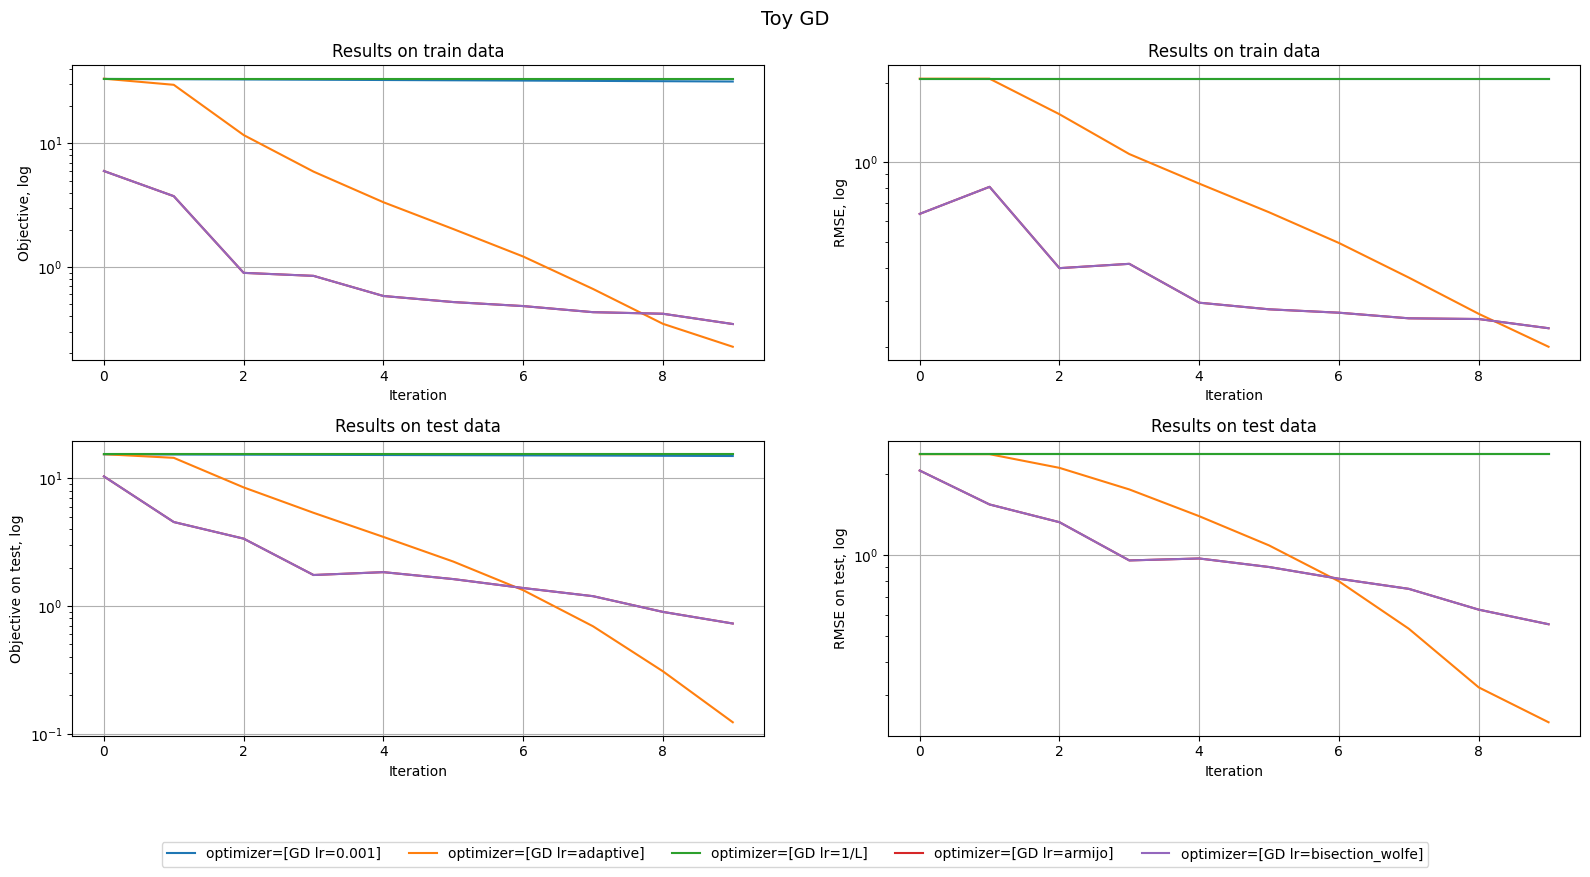

(tensor([[2.0000, 3.0000, 2.0000, 3.6246, 2.7407],
         [2.6201, 2.0000, 2.4494, 4.0000, 6.2572],
         [3.0000, 2.4607, 3.0000, 4.3466, 4.0000],
         [1.5734, 3.0000, 2.5610, 4.0000, 5.6783],
         [2.1198, 1.0000, 1.0094, 1.6330, 2.0000],
         [1.0000, 8.0261, 3.0000, 4.0000, 2.4934]], device='cuda:0'),
 0.2382534146308899,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a4d7d9e20>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_toy_res = choose_best(
    toy_matrix_full,
    toy_mask,
    toy_test_mask,
    block_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-3),
                    AdaptiveStep(),
                    Estimate1OverL(),
                    Armijo(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy GD")

gd_toy_res[:-1]

100%|██████████| 100/100 [01:23<00:00,  1.19it/s, Objective=911, RMSE=0.784, Objective[test]=562, RMSE[test]=0.863]    


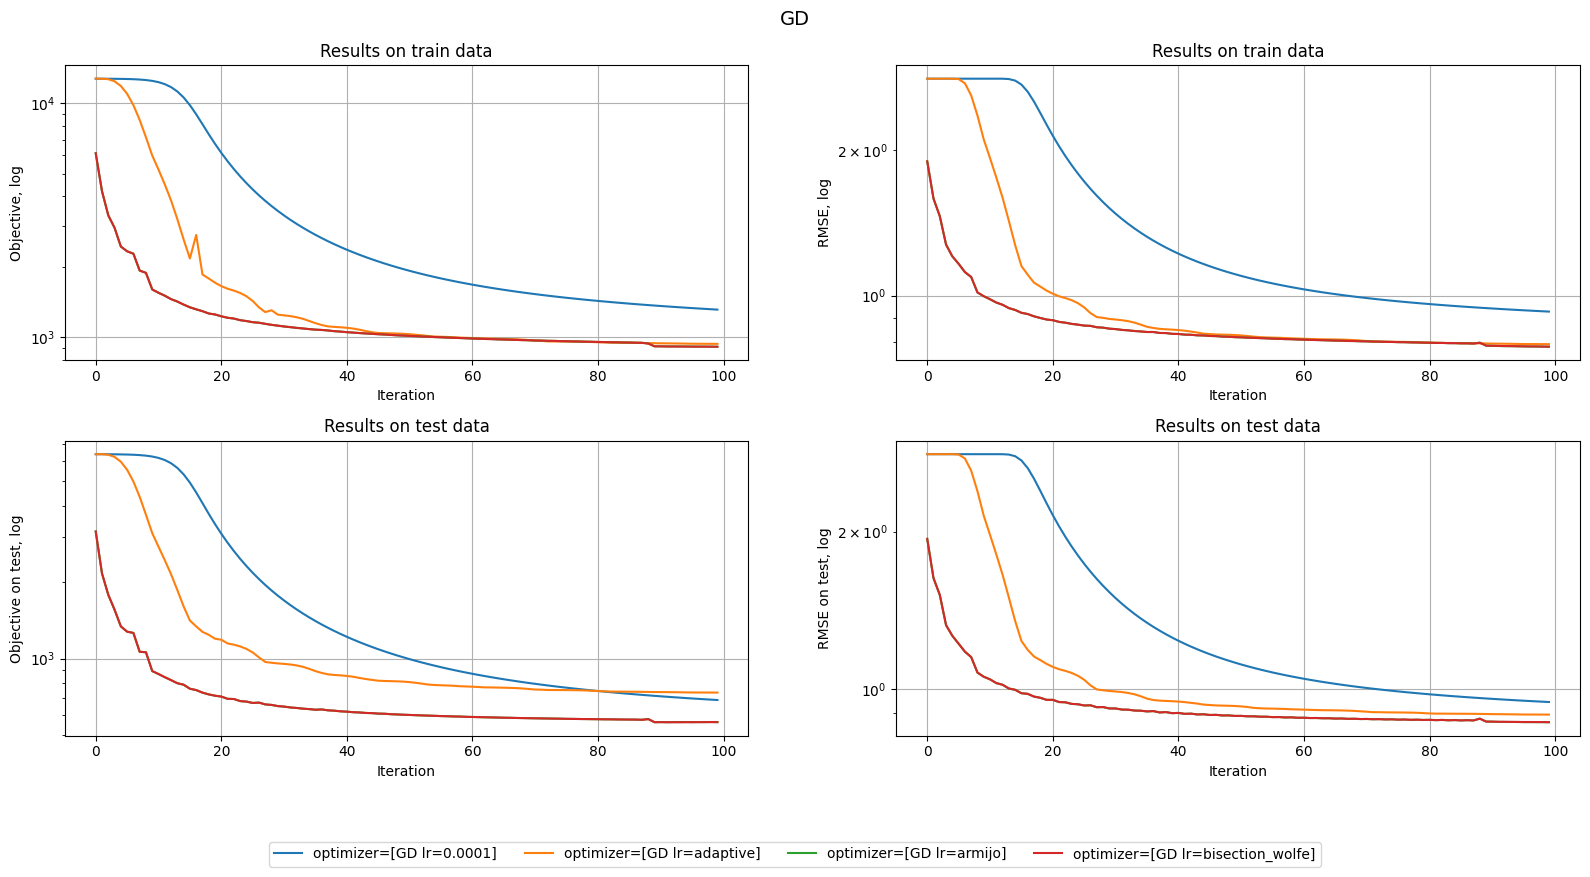

(tensor([[5.0000, 3.3399, 3.2535,  ..., 2.9133, 2.9538, 3.3430],
         [3.9298, 2.8987, 3.1492,  ..., 3.3157, 3.1762, 3.9232],
         [3.8092, 3.2137, 3.4324,  ..., 3.0978, 2.6308, 3.8792],
         ...,
         [3.5111, 2.5925, 2.4500,  ..., 2.8618, 3.0007, 3.5180],
         [3.6959, 2.6916, 2.1002,  ..., 3.0684, 3.4047, 3.2644],
         [3.0000, 1.4764, 1.0000,  ..., 3.5493, 4.7070, 3.4916]],
        device='cuda:0'),
 0.862877368927002,
 {'rank': 10,
  'iterations': 100,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a4d6b5af0>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 100,
        "init_strategy": "mean",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                GradientDescent(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-4),
                    AdaptiveStep(),
                    # Estimate1OverL(),
                    Armijo(),
                    BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 100/100 [02:50<00:00,  1.71s/it, Objective=831, RMSE=0.743, Objective[test]=647, RMSE[test]=0.89]     


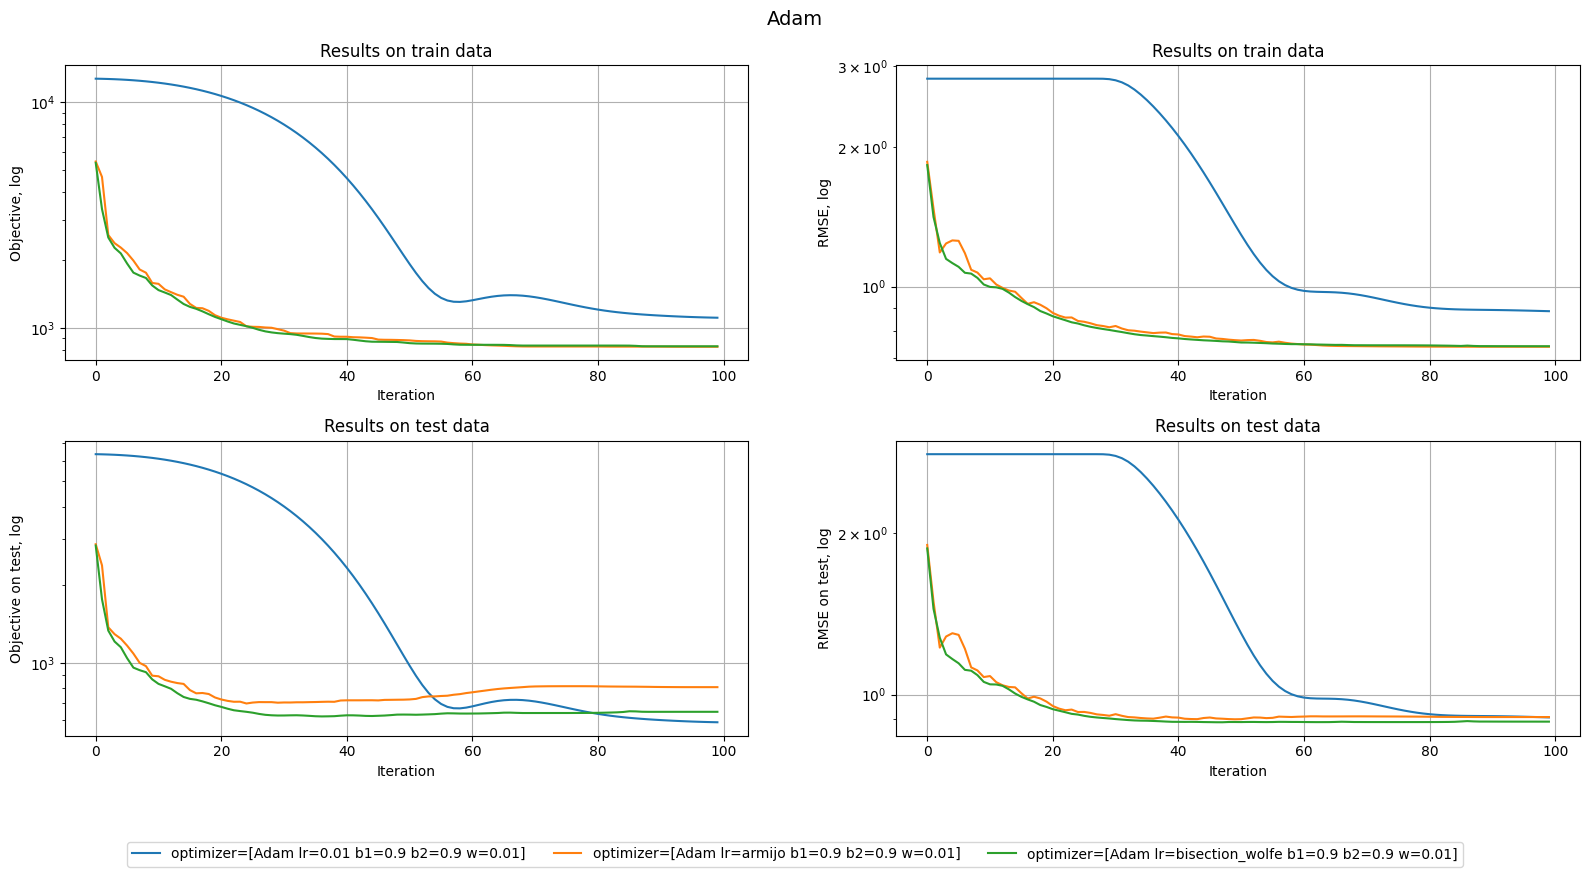

(tensor([[5.0000, 3.2814, 3.1867,  ..., 4.1732, 3.6380, 3.3939],
         [4.5714, 3.3045, 3.1049,  ..., 4.8269, 3.9116, 4.1961],
         [4.1256, 3.1031, 3.3424,  ..., 4.1902, 3.9712, 3.6906],
         ...,
         [4.1453, 3.6199, 2.9842,  ..., 3.5554, 5.0000, 5.0000],
         [4.0234, 3.2709, 2.7532,  ..., 3.9955, 4.5019, 4.0713],
         [3.0000, 2.0223, 1.1780,  ..., 3.0457, 3.9483, 3.8495]],
        device='cuda:0'),
 0.8902669548988342,
 {'rank': 10,
  'iterations': 100,
  'init_strategy': 'mean',
  'optimizer': <__main__.Adam at 0x24a86586bd0>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 100,
        "init_strategy": "mean",
        "optimizer": [
            (str(optimizer), optimizer)
            for optimizer in [
                Adam(lr_scheduler=lr_scheduler)
                for lr_scheduler in [
                    Normal(1e-2),
                    # AdaptiveStep(),
                    # Estimate1OverL(),
                    # Armijo(),
                    # BisectionWolfe(),
                ]
            ]
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "Adam")

gd_res[:-1]

100%|██████████| 150/150 [00:27<00:00,  5.47it/s, Objective=774, RMSE=0.712, Objective[test]=773, RMSE[test]=0.917]    


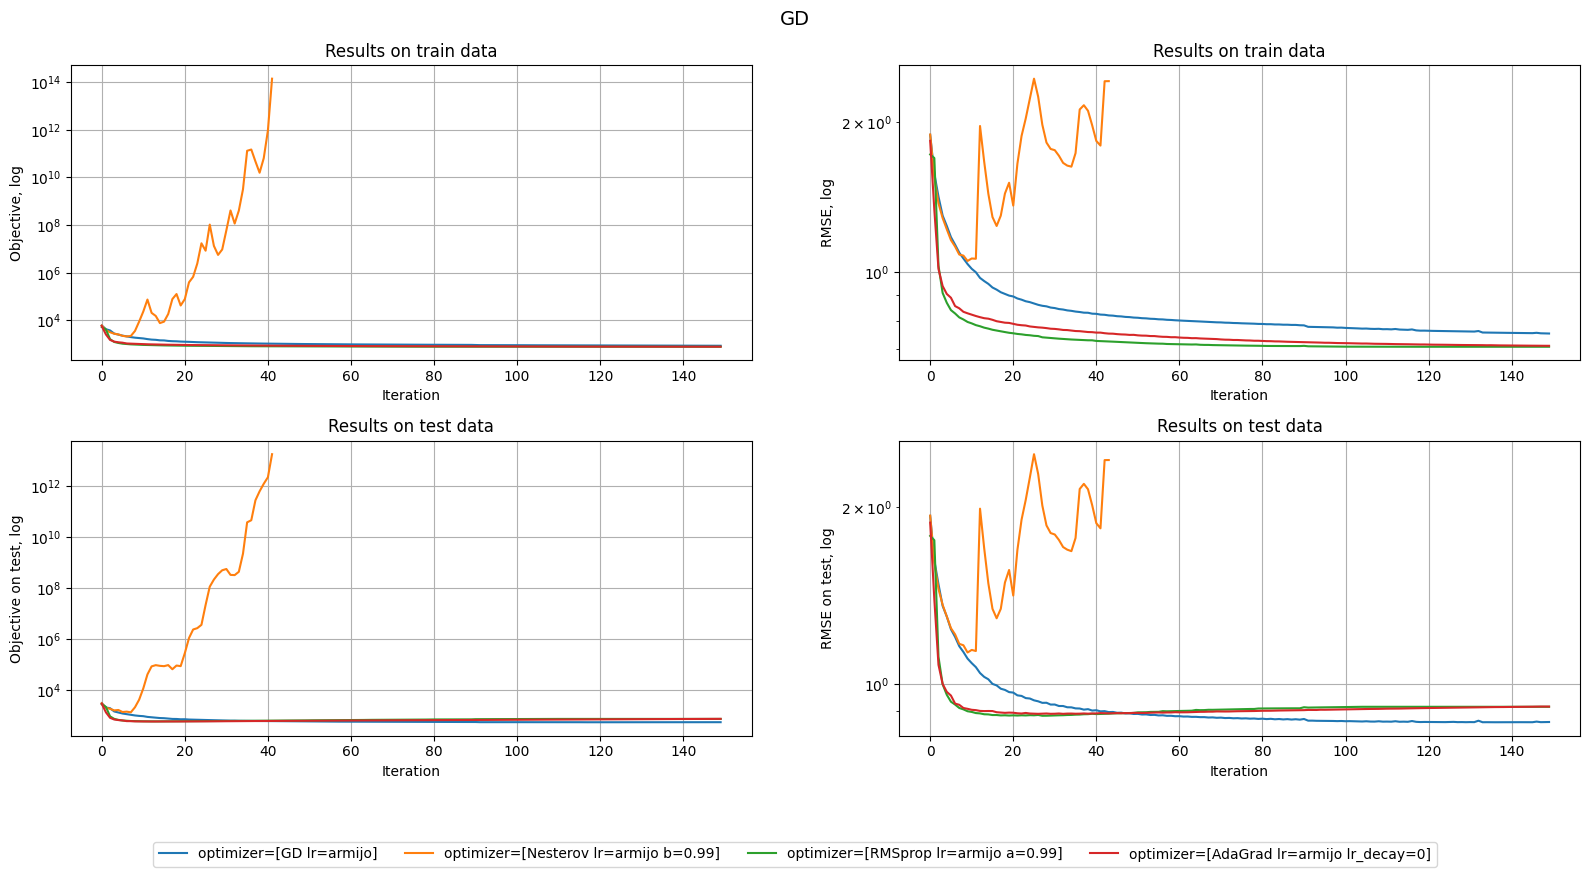

(tensor([[5.0000, 3.2156, 3.4946,  ..., 3.1942, 3.1258, 3.5128],
         [4.3858, 3.0924, 3.5639,  ..., 3.4255, 3.1114, 3.9292],
         [4.0895, 3.3185, 3.9818,  ..., 3.2501, 2.5168, 3.8914],
         ...,
         [3.6401, 2.6101, 2.3763,  ..., 3.0742, 3.2270, 3.7263],
         [3.8382, 2.7136, 2.4733,  ..., 3.1719, 3.4207, 3.4522],
         [3.0000, 1.6935, 1.0000,  ..., 3.2796, 4.6147, 3.5903]],
        device='cuda:0'),
 0.8632461428642273,
 {'rank': 12,
  'iterations': 150,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a8031a3c0>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 12,
        "iterations": 150,
        "init_strategy": "mean",
        "optimizer": [
            GradientDescent(lr_scheduler=Armijo()),
            # Nesterov(lr_scheduler=Armijo()),
            RMSprop(lr_scheduler=Armijo()),
            AdaGrad(lr_scheduler=Armijo()),
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 200/200 [01:12<00:00,  2.75it/s, Objective=826, RMSE=0.743, Objective[test]=579, RMSE[test]=0.866]     


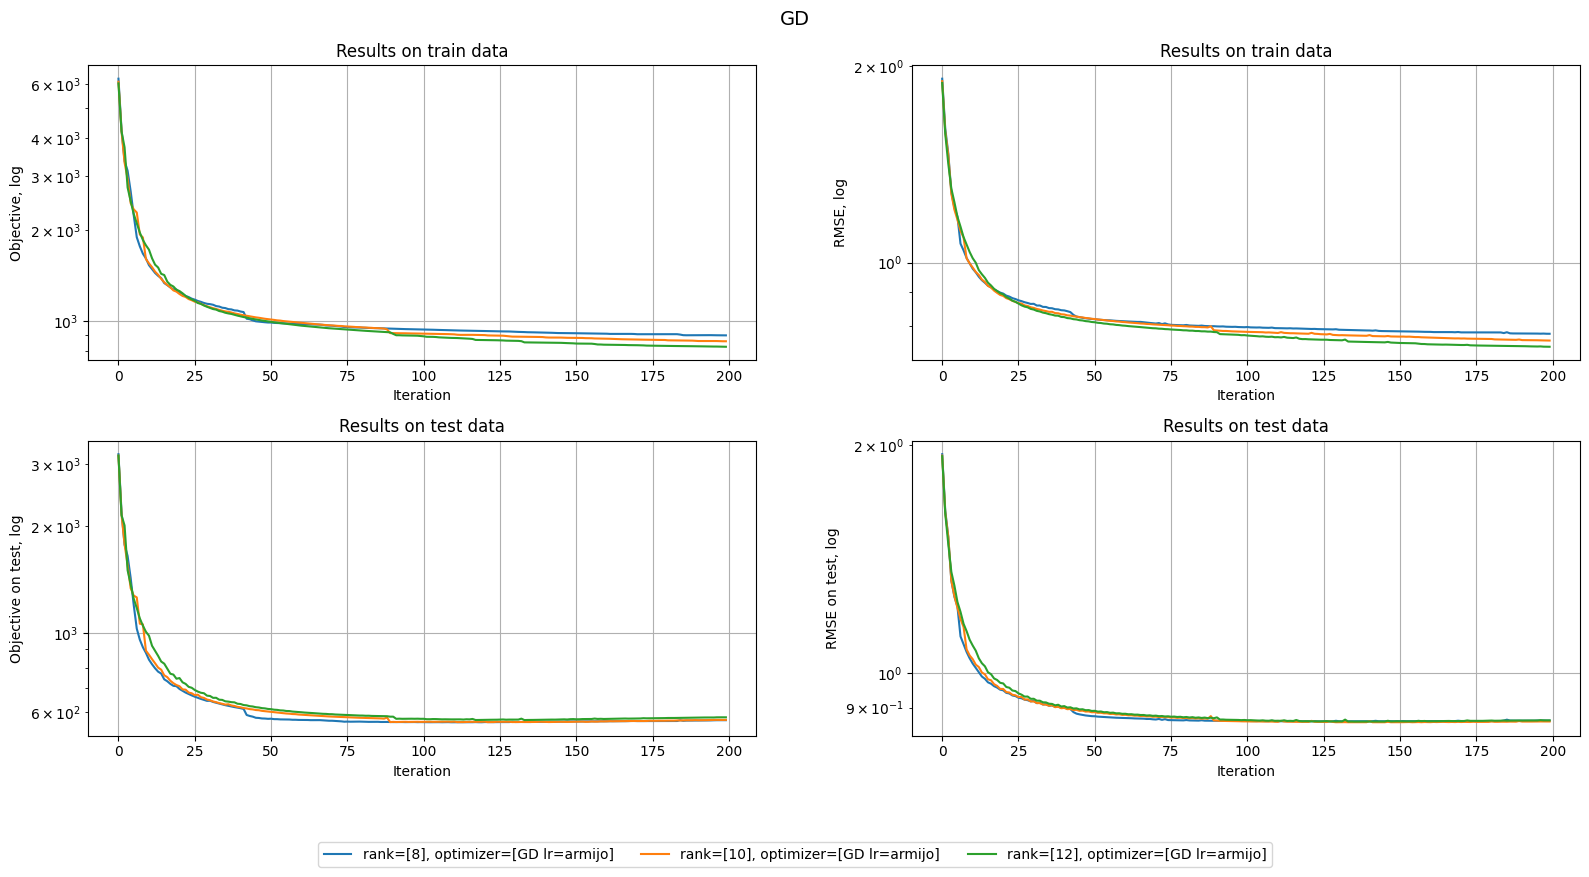

(tensor([[5.0000, 3.1853, 3.2916,  ..., 3.4073, 3.3703, 3.5075],
         [4.2693, 3.1630, 3.4337,  ..., 3.5896, 3.2232, 3.9115],
         [3.7414, 3.2820, 3.6726,  ..., 3.5600, 2.7664, 3.9841],
         ...,
         [3.5413, 2.7014, 2.6005,  ..., 3.3164, 3.5200, 4.0624],
         [3.7932, 2.6217, 2.2867,  ..., 3.3836, 3.7363, 3.7197],
         [3.0000, 1.4178, 1.0000,  ..., 3.1709, 4.6684, 3.6990]],
        device='cuda:0'),
 0.8626747727394104,
 {'rank': 10,
  'iterations': 200,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a4a7e9e80>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": [8, 10, 12],
        "iterations": 200,
        "init_strategy": "mean",
        "optimizer": [
            GradientDescent(lr_scheduler=Armijo()),
        ],
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [ ]:
# save_solution(gd_res[0], decimals=5, prefix="gd10_")

100%|██████████| 420/420 [00:32<00:00, 12.97it/s, Objective=658, RMSE=0.646, Objective[test]=508, RMSE[test]=0.82]        


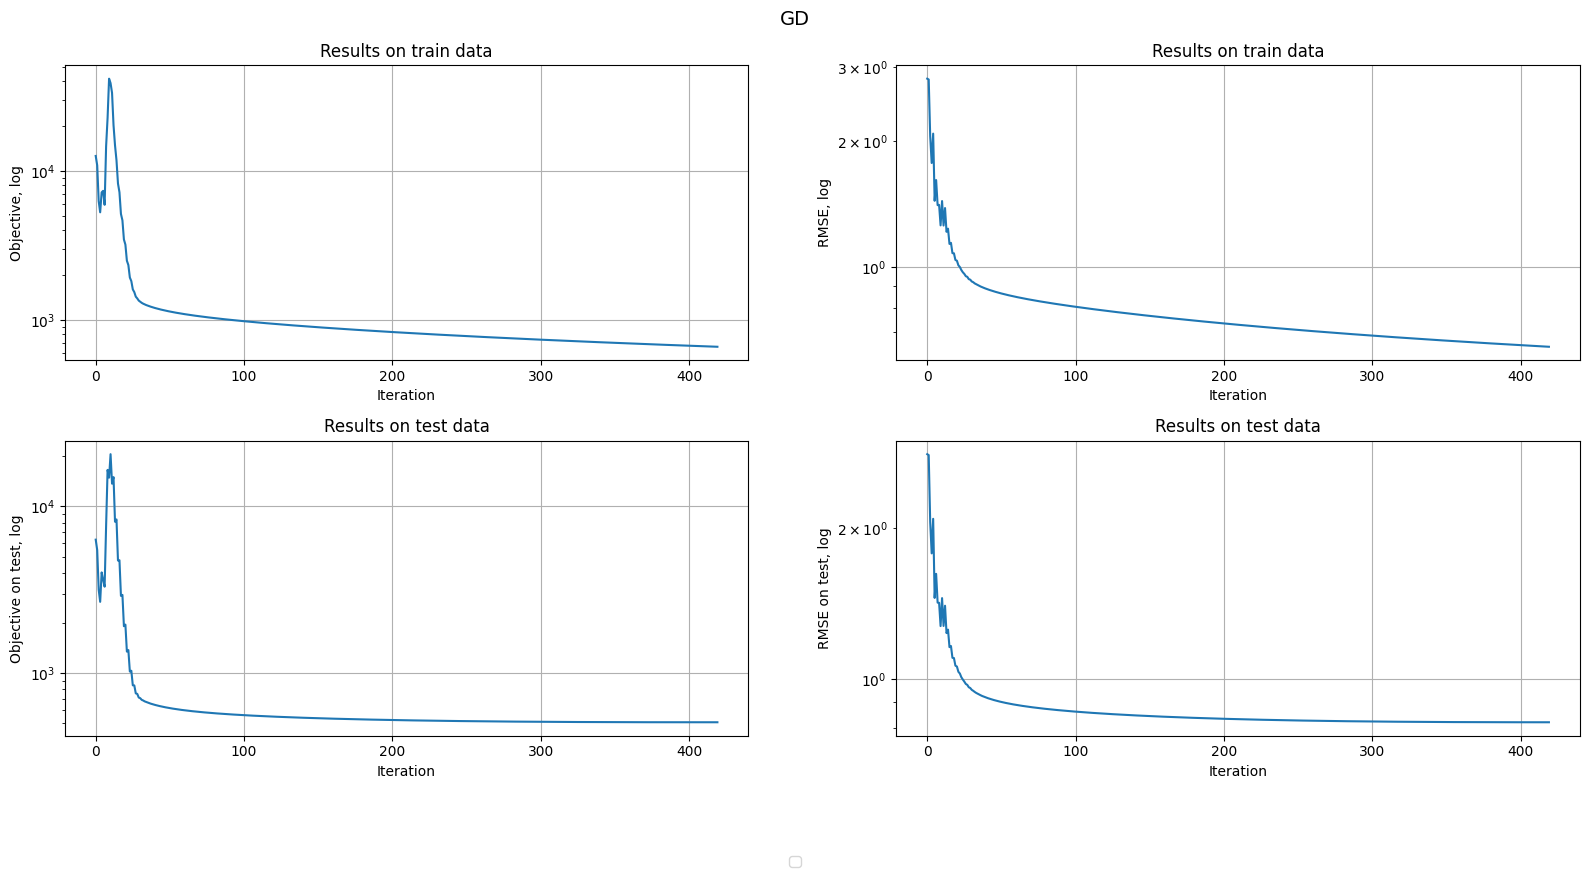

(tensor([[5.0000, 3.4933, 3.2227,  ..., 3.7155, 4.0858, 3.9562],
         [4.0802, 3.3811, 3.1074,  ..., 3.4501, 3.7138, 3.8275],
         [4.4936, 3.5336, 3.4363,  ..., 3.5713, 3.7853, 3.8369],
         ...,
         [4.0340, 3.0216, 2.6836,  ..., 3.3943, 3.7519, 3.7268],
         [4.3038, 2.9841, 2.8805,  ..., 3.5141, 3.9046, 3.7214],
         [3.0000, 1.8968, 1.6157,  ..., 3.2875, 3.9034, 3.4095]],
        device='cuda:0'),
 0.8202496767044067,
 {'rank': 80,
  'iterations': 420,
  'init_strategy': 'mean',
  'optimizer': <__main__.GradientDescent at 0x24a3e3f1340>,
  'regularization': 0,
  'verbose': True})

In [ ]:
gd_res = choose_best(
    real_matrix_full,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 80,
        "iterations": 420,
        "init_strategy": "mean",
        "optimizer": GradientDescent(
            lr_scheduler=Normal(
                lambda k: 1e-3 / np.sqrt(k),
            )
        ),
        "regularization": 0,
        "verbose": True,
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

In [371]:
save_solution(gd_res[0], decimals=5, prefix="gd80_")

100%|██████████| 10/10 [00:00<00:00, 23.52it/s, Objective=7.29e+3, RMSE=2.33, RMSE Test=1.29]


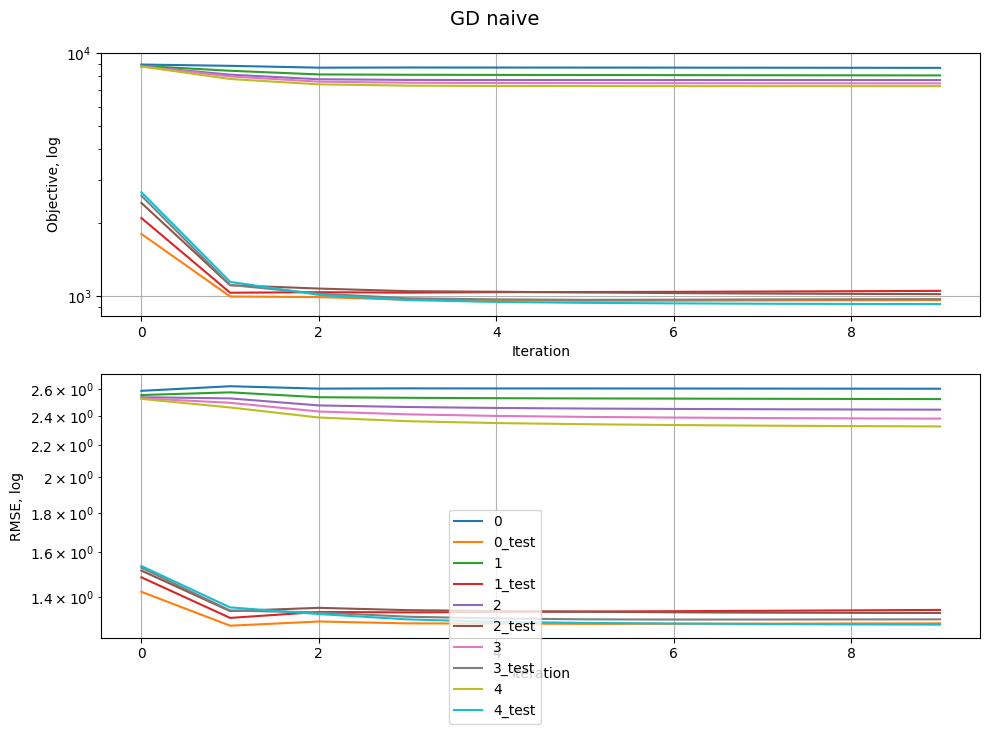

(tensor([[5.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.2508, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [3.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
        device='cuda:0'),
 2.326040029525757,
 {'rank': 100,
  'iterations': 10,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 0.001,
  'lr_strategy': 'normal'})

In [ ]:
gd_res_nnmf = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    nnmf_gd,
    {
        "rank": [10, 25, 50, 75, 100],
        "iterations": 10,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_res_nnmf[-1], "GD naive")

gd_res_nnmf[:-1]

In [ ]:
def nabla_objective_gd_cords(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    u: torch.Tensor,
    v: torch.Tensor,
    i: int,
    j: int,
    for_v: bool = False,
    regularization: float = 0.0,
) -> torch.Tensor:
    if for_v:
        return -(matrix[i, j] - torch.dot(u[i, :], v[:, j])) * u[
            i, :
        ] - regularization * v[:, j]

    return -(matrix[i, j] - torch.dot(u[i, :], v[:, j])) * v[:, j] - regularization * u[
        i, :
    ]


def coordinate_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.Tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()
    print(matrix.shape)
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            # Naive approach
            # Update only U
            for i in range(matrix.shape[0]):
                indices = torch.where(mask[i, :] > 0)[0]
                for j_tens in indices:
                    j = j_tens.item()
                    if lr_strategy == "adaptive":
                        # Adaptive step
                        grad_u = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, regularization=regularization
                        )
                        stepu, thetau = adaptive_step(
                            u,
                            prev_u,
                            grad_u,
                            prev_grad_u,
                            stepu,
                            thetau,
                            start_step=lr_func(0),
                        )
                        prev_grad_u = grad_u.clone()

                        prev_u = u.clone()
                        u[i, :] = u_optim.step(
                            u[i, :],
                            grad_u,
                            stepu,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, x, v, i, j, regularization=regularization
                            ),
                        )
                    elif lr_strategy == "normal":
                        # Ordinary
                        alpha_u = alpha_v = lr_func(k)
                        grad_u = nabla_objective_gd_cords(
                            matrix, mask, u, v, i, j, regularization=regularization
                        )
                        u[i, :] = u_optim.step(
                            u[i, :],
                            grad_u,
                            alpha_u,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix, mask, x, v, i, j, regularization=regularization
                            ),
                        )

                    # err_ij = matrix[i, j] - torch.dot(u[i, :], v[:, j])
                    # u[i, :] += lr * (err_ij * v[:, j] - regularization * u[i, :])

            for j in range(matrix.shape[1]):
                indices = torch.where(mask[:, j] > 0)[0]
                for i_tens in indices:
                    i = i_tens.item()
                    if lr_strategy == "adaptive":
                        grad_v = nabla_objective_gd_cords(
                            matrix,
                            mask,
                            u,
                            v,
                            i,
                            j,
                            for_v=True,
                            regularization=regularization,
                        )
                        stepv, thetav = adaptive_step(
                            v,
                            prev_v,
                            grad_v,
                            prev_grad_v,
                            stepv,
                            thetav,
                            start_step=lr_func(0),
                        )
                        prev_grad_v = grad_v.clone()

                        prev_v = v.clone()
                        v[:, j] = v_optim.step(
                            v[:, j],
                            grad_v,
                            stepv,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix,
                                mask,
                                u,
                                x,
                                i,
                                j,
                                for_v=True,
                                regularization=regularization,
                            ),
                        )
                    elif lr_strategy == "normal":
                        grad_v = nabla_objective_gd_cords(
                            matrix,
                            mask,
                            u,
                            v,
                            i,
                            j,
                            for_v=True,
                            regularization=regularization,
                        )
                        v[:, j] = v_optim.step(
                            v[:, j],
                            grad_v,
                            alpha_v,
                            k,
                            lambda x: nabla_objective_gd_cords(
                                matrix,
                                mask,
                                u,
                                x,
                                i,
                                j,
                                for_v=True,
                                regularization=regularization,
                            ),
                        )

                    # err_ij = matrix[i, j] - torch.dot(u[i, :], v[:, j])
                    # v[:, j] += lr * (err_ij * u[i, :] - regularization * v[:, j])

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(
                matrix, test_mask, u, v, regularization=regularization
            )

            rmse_sc = rmse_score(matrix, predict_matrix(u, v), mask)
            rmse_sc_test = rmse_score(matrix, predict_matrix(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix({"Objective": objective, "RMSE": rmse_sc})

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * predict_matrix(u, v), log_dict


def nnmf_gd(
    matrix: torch.Tensor,
    mask: torch.Tensor,
    test_mask: torch.Tensor,
    rank: int | float,
    iterations: int,
    optimizer: Callable[[], Optimizer] = GradientDescent,
    lr: Callable[[int], float] | float = 1e-3,
    init_strategy: Literal["random", "svd"] = "svd",
    regularization: float = 0.0,
    clip: bool = False,
    lr_strategy: Literal[
        "normal",
        "adaptive",
        "bisection",
        "armijo_rule",
        "1/L",
    ] = "normal",
    verbose: bool = True,
    seed: int = 420,
) -> tuple[torch.Tensor, dict]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    r = int(min(matrix.shape) * rank) if isinstance(rank, float) else rank

    # Initializing
    u, v = init_gd(matrix, mask, r, strategy=init_strategy)
    u = torch.clip(u, 0)
    v = torch.clip(v, 0)

    log_dict = {
        "objective": [],
        "objective_test": [],
        "rmse": [],
        "rmse_test": [],
    }
    u_optim = optimizer()
    v_optim = optimizer()

    lr_func: Callable[[int], float] = (lambda _: lr) if isinstance(lr, float) else lr  # type: ignore

    # For adaprive
    stepu = None
    stepv = None

    thetau = 0
    thetav = 0

    prev_grad_u = 0
    prev_grad_v = 0

    prev_u = u.clone()
    prev_v = v.clone()

    eps = 1e-10
    F = u @ torch.ones(rank).float().to(DEVICE)
    with tqdm.tqdm(range(iterations), disable=not verbose) as loop:
        for k in loop:
            # Naive approach
            # Update only U

            A = matrix @ v.T
            B = v @ v.T

            for j in range(rank):
                uj = F - u[:, j]
                h = A[:, j] - u @ B[:, j] + B[j, j] * u[:, j]
                u[:, j] = torch.max(
                    torch.zeros(len(h)).float().to(DEVICE) + eps,
                    h - (uj @ h) / (uj @ uj) * uj,
                )
                u[:, j] = u[:, j] / torch.pow(
                    (u[:, j] @ u[:, j]), 1 / 2
                )  # мб взять корень для нормализации
                F = uj + u[:, j]

            C = matrix.T @ u
            D = u.T @ u

            for j in range(rank):
                v[j, :] = torch.max(
                    torch.zeros(len(v[j, :])).float().to(DEVICE) + eps,
                    C[:, j] - v.T @ D[:, j] + D[j, j] * v[j, :],
                )

            if clip:
                u = torch.clip(u, 0)
                v = torch.clip(v, 0)

            # log
            objective = objective_gd(matrix, mask, u, v, regularization=regularization)
            objective_test = objective_gd(
                matrix, test_mask, u, v, regularization=regularization
            )

            rmse_sc = rmse_score(matrix, predict_matrix(u, v), mask)
            rmse_sc_test = rmse_score(matrix, predict_matrix(u, v), test_mask)
            log_dict["objective"].append(objective)
            log_dict["objective_test"].append(objective_test)
            log_dict["rmse"].append(rmse_sc)
            log_dict["rmse_test"].append(rmse_sc_test)
            if verbose:
                loop.set_postfix(
                    {"Objective": objective, "RMSE": rmse_sc, "RMSE Test": rmse_sc_test}
                )

        log_dict["iteration"] = list(range(len(log_dict["objective"])))

        return matrix + (~mask) * predict_matrix(u, v), log_dict

100%|██████████| 10/10 [00:00<00:00, 59.72it/s, Objective=0.198, RMSE=0.155]


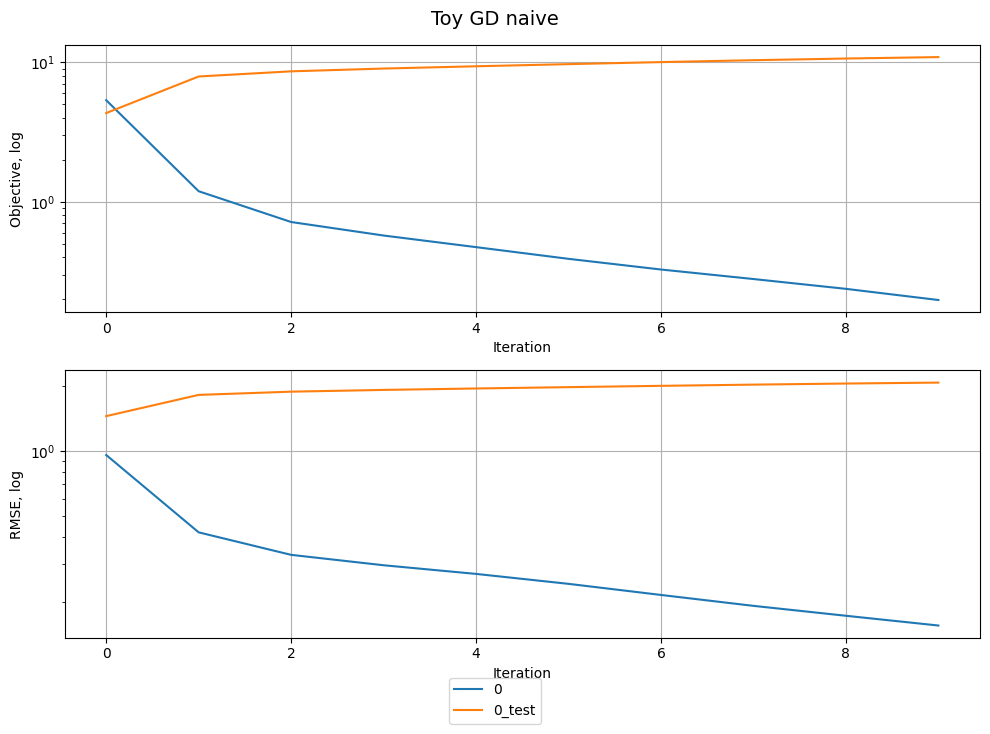

(tensor([[2.0000, 3.0000, 2.0000, 1.5241, 2.0956],
         [1.0000, 2.0000, 1.8913, 4.0000, 1.0000],
         [3.0000, 3.7639, 3.0000, 1.0000, 4.0000],
         [1.0000, 3.0000, 2.7349, 4.0000, 1.0000],
         [1.5018, 2.2357, 1.8548, 1.0000, 2.0000],
         [1.0000, 3.3003, 3.0000, 4.0000, 1.2152]], device='cuda:0'),
 0.1551935374736786,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.RMSprop,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'normal'})

In [ ]:
gd_toy_res_cord = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    coordinate_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-1,
        "optimizer": RMSprop,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_toy_res_cord[-1], "Toy GD naive")

gd_toy_res_cord[:-1]

torch.Size([6040, 3952])


100%|██████████| 10/10 [55:26<00:00, 332.61s/it, Objective=nan, RMSE=nan]    


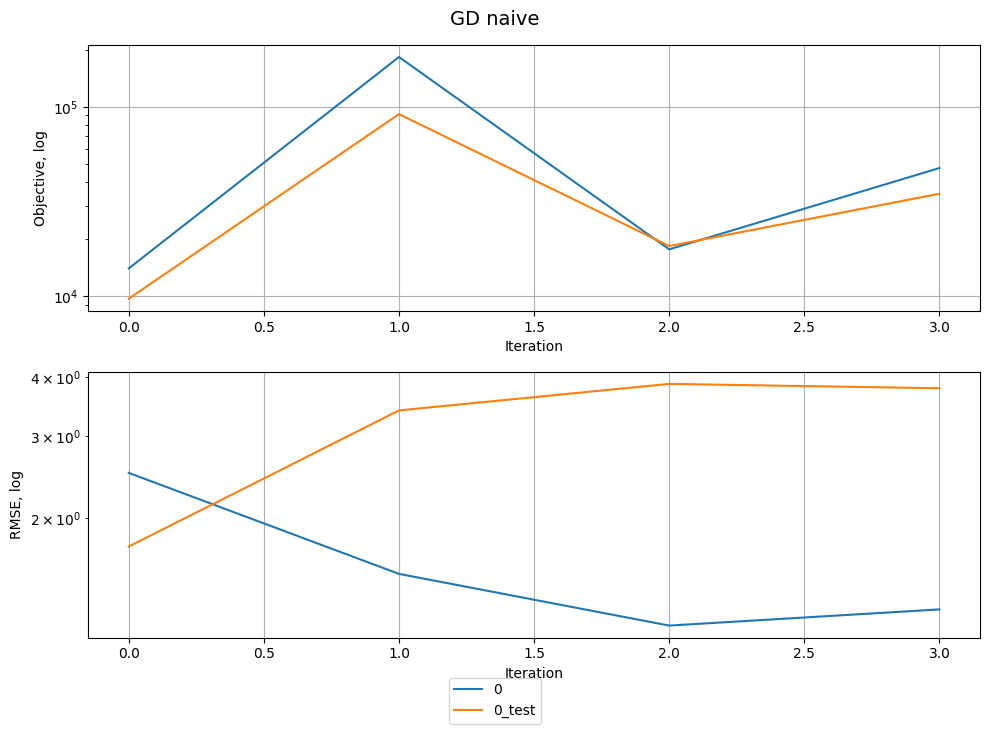

(array([0.]), 1000.0, {})

In [ ]:
gd_res_cord = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    coordinate_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 1e-1,
        "clip": False,
        "lr": 1e-2,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(gd_res_cord[-1], "GD naive")

gd_res_cord[:-1]

100%|██████████| 10/10 [00:00<00:00, 86.50it/s, Objective=0.149, RMSE=0.153]


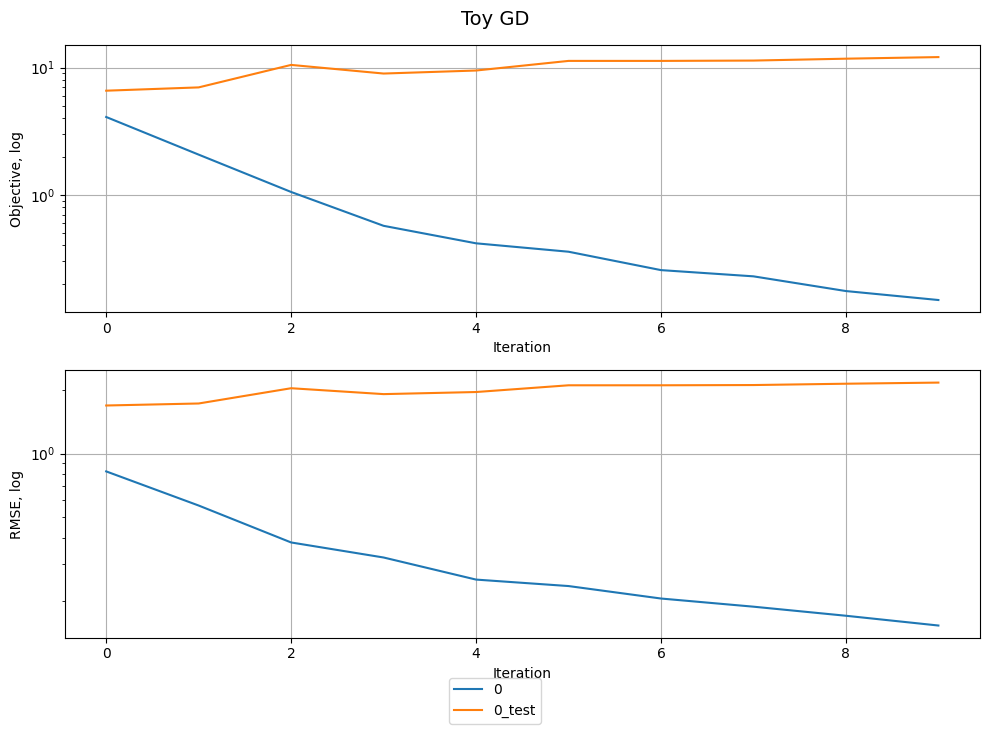

(tensor([[2.0000, 3.0000, 2.0000, 2.7468, 2.8031],
         [1.0000, 2.0000, 2.1565, 4.0000, 1.0000],
         [3.0000, 3.8533, 3.0000, 3.4516, 4.0000],
         [1.0000, 3.0000, 2.5099, 4.0000, 1.0000],
         [1.8218, 1.3039, 1.0000, 1.0000, 2.0000],
         [1.0000, 3.4770, 3.0000, 4.0000, 2.3063]], device='cuda:0'),
 0.15337860584259033,
 {'rank': 2,
  'iterations': 10,
  'init_strategy': 'mean',
  'lr': 0.1,
  'optimizer': __main__.GradientDescent,
  'verbose': True,
  'regularization': 0,
  'lr_strategy': 'bisection'})

In [ ]:
gd_toy_res = choose_best(
    toy_matrix,
    toy_mask,
    toy_test_mask,
    block_gd,
    {
        "rank": 2,
        "iterations": 10,
        "init_strategy": "mean",
        "lr": 1e-1,
        "optimizer": GradientDescent,
        "verbose": True,
        "regularization": 0,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_toy_res[-1], "Toy GD")

gd_toy_res[:-1]

100%|██████████| 100/100 [00:14<00:00,  6.84it/s, Objective=913, RMSE=0.783]   


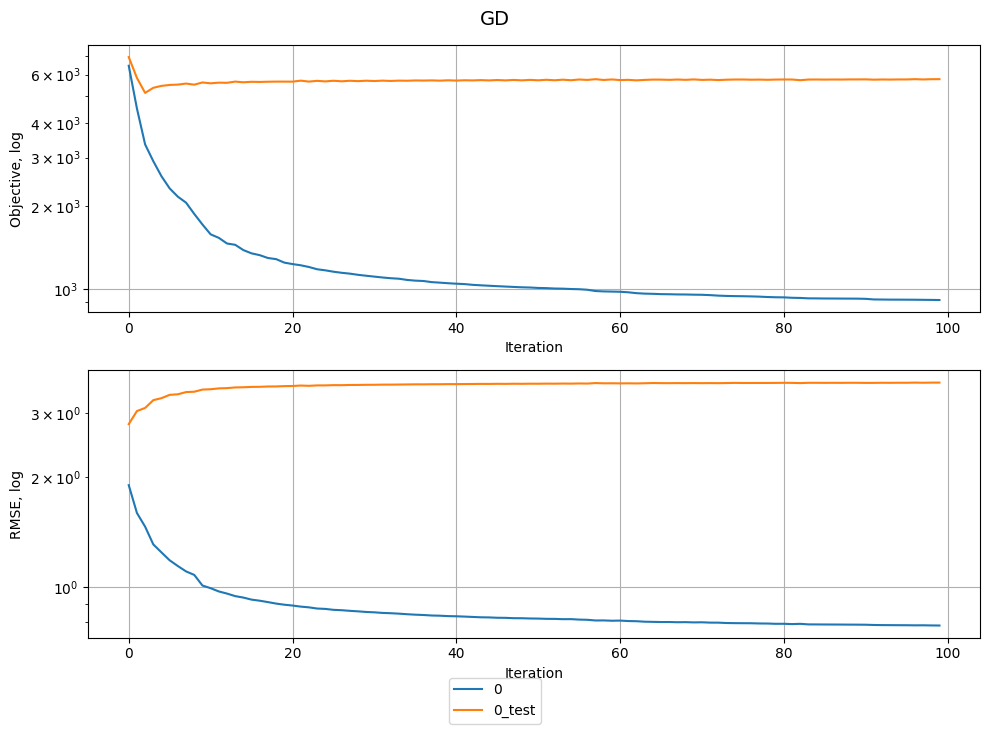

(tensor([[5.0000, 3.3997, 3.2944,  ..., 2.9080, 2.8253, 3.3777],
         [3.8702, 2.9555, 3.1424,  ..., 3.2914, 3.0654, 3.9299],
         [3.7768, 3.2901, 3.5227,  ..., 3.0482, 2.5501, 3.9151],
         ...,
         [3.6132, 2.5510, 2.5101,  ..., 2.8648, 2.9242, 3.5902],
         [3.6859, 2.6066, 2.1818,  ..., 3.0362, 3.2458, 3.2782],
         [3.0000, 1.4490, 1.0000,  ..., 3.5622, 4.5139, 3.4821]],
        device='cuda:0'),
 0.783055305480957,
 {'rank': 10,
  'iterations': 100,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 0.01,
  'lr_strategy': 'bisection'})

In [ ]:
gd_bis_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 100,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-2,
        "lr_strategy": "bisection",
    },
)

plot_log_dicts(gd_bis_res[-1], "GD")

gd_bis_res[:-1]

100%|██████████| 500/500 [00:06<00:00, 81.34it/s, Objective=896, RMSE=0.773]   


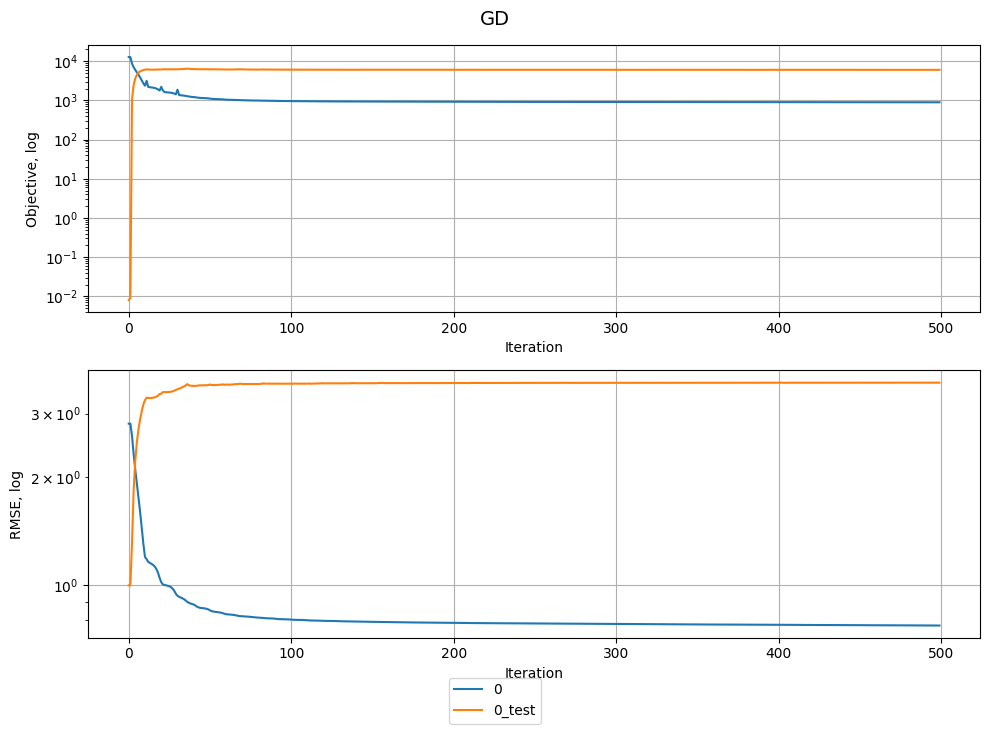

(tensor([[5.0000, 3.6355, 3.5984,  ..., 3.9750, 4.1839, 3.7113],
         [4.5044, 3.3758, 3.3407,  ..., 3.7192, 3.9229, 3.8037],
         [3.5508, 3.5909, 3.6401,  ..., 3.0027, 3.0546, 3.3285],
         ...,
         [5.0000, 1.0000, 1.0000,  ..., 3.0825, 3.9006, 4.0787],
         [3.6469, 3.2007, 2.9571,  ..., 3.5705, 3.8981, 3.7457],
         [3.0000, 1.5077, 1.1421,  ..., 3.6881, 4.2617, 3.7305]],
        device='cuda:0'),
 0.7732722163200378,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.GradientDescent,
  'regularization': 0,
  'clip': False,
  'lr': 1e-10,
  'lr_strategy': 'adaptive'})

In [ ]:
gd_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": GradientDescent,
        "regularization": 0,
        "clip": False,
        "lr": 1e-10,
        "lr_strategy": "adaptive",
    },
)

plot_log_dicts(gd_res[-1], "GD")

gd_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.13it/s, Objective=895, RMSE=0.775]   


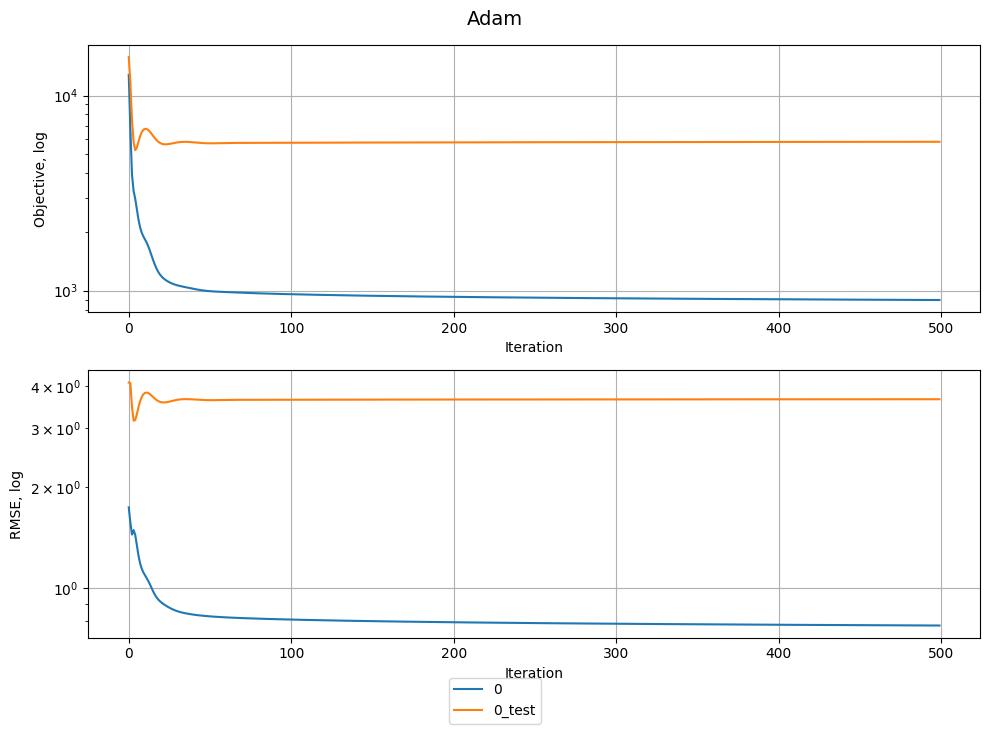

(tensor([[5.0000, 3.4823, 3.3868,  ..., 4.4622, 3.9544, 4.4801],
         [4.3352, 3.3324, 3.3773,  ..., 4.5636, 3.9818, 4.0872],
         [4.0779, 3.1255, 3.6004,  ..., 4.0890, 4.3622, 3.3005],
         ...,
         [3.8376, 2.7349, 3.4034,  ..., 3.3765, 3.7374, 2.4218],
         [3.9036, 2.9043, 2.8508,  ..., 3.8635, 3.9503, 3.7408],
         [3.0000, 1.9666, 1.1238,  ..., 3.1099, 4.8159, 3.5804]],
        device='cuda:0'),
 0.7750696539878845,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Adam,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [ ]:
adam_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Adam,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: 1 / (k + 1),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adam_res[-1], "Adam")

adam_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.10it/s, Objective=822, RMSE=0.74]     


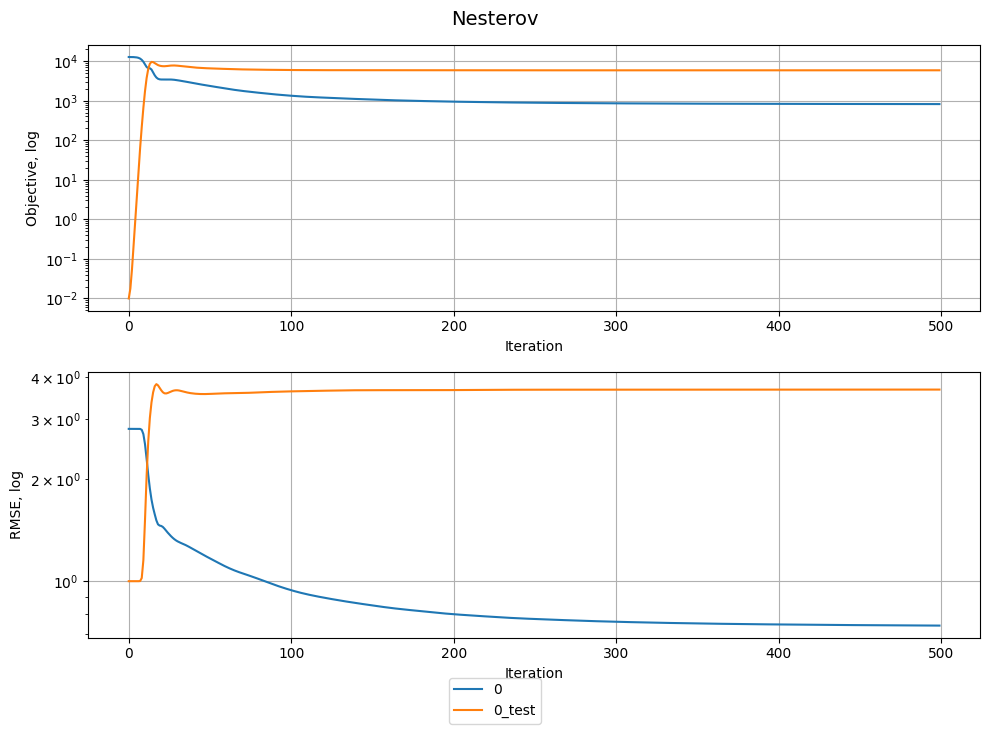

(tensor([[5.0000, 3.2127, 3.1560,  ..., 4.0730, 3.6891, 3.4230],
         [4.5666, 3.2502, 3.7406,  ..., 5.0000, 3.6281, 3.7640],
         [3.5054, 3.0563, 3.9330,  ..., 4.5392, 4.1960, 3.9267],
         ...,
         [3.8870, 3.6306, 3.1158,  ..., 4.3416, 5.0000, 5.0000],
         [3.7149, 3.0422, 2.8310,  ..., 3.5852, 4.3692, 3.9709],
         [3.0000, 1.6427, 1.0000,  ..., 3.0450, 4.6840, 3.8462]],
        device='cuda:0'),
 0.7397009134292603,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.Nesterov,
  'regularization': 0,
  'clip': False,
  'lr': <function __main__.<lambda>(k)>,
  'lr_strategy': 'normal'})

In [ ]:
nesterov_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": Nesterov,
        "regularization": 0,
        "clip": False,
        "lr": lambda k: max(1e-4 / np.sqrt(k + 1), 1e-6),
        "lr_strategy": "normal",
    },
)

plot_log_dicts(nesterov_res[-1], "Nesterov")

nesterov_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 86.91it/s, Objective=861, RMSE=0.757]    


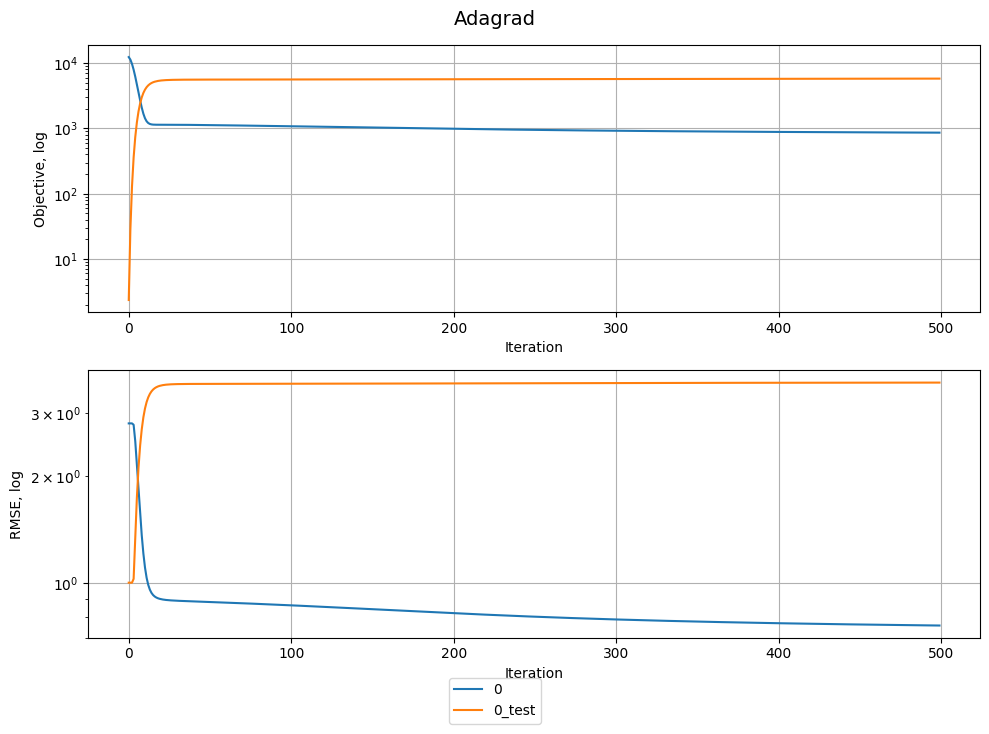

(tensor([[5.0000, 3.6569, 3.4432,  ..., 4.0861, 3.5065, 3.9579],
         [4.2649, 3.5046, 3.2638,  ..., 4.2494, 3.9642, 3.9375],
         [4.1146, 3.5355, 3.7461,  ..., 4.1596, 4.8135, 4.0014],
         ...,
         [3.1801, 2.4239, 2.4107,  ..., 3.5083, 5.0000, 3.7553],
         [3.9549, 3.1263, 2.7542,  ..., 3.7172, 4.5162, 3.9736],
         [3.0000, 2.2475, 1.4865,  ..., 2.8222, 4.7049, 3.5275]],
        device='cuda:0'),
 0.7572656273841858,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.AdaGrad,
  'regularization': 0,
  'clip': False,
  'lr': 0.1,
  'lr_strategy': 'normal'})

In [ ]:
adagrad_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": AdaGrad,
        "regularization": 0,
        "clip": False,
        "lr": 1e-1,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(adagrad_res[-1], "Adagrad")

adagrad_res[:-1]

100%|██████████| 500/500 [00:05<00:00, 87.16it/s, Objective=848, RMSE=0.751]    


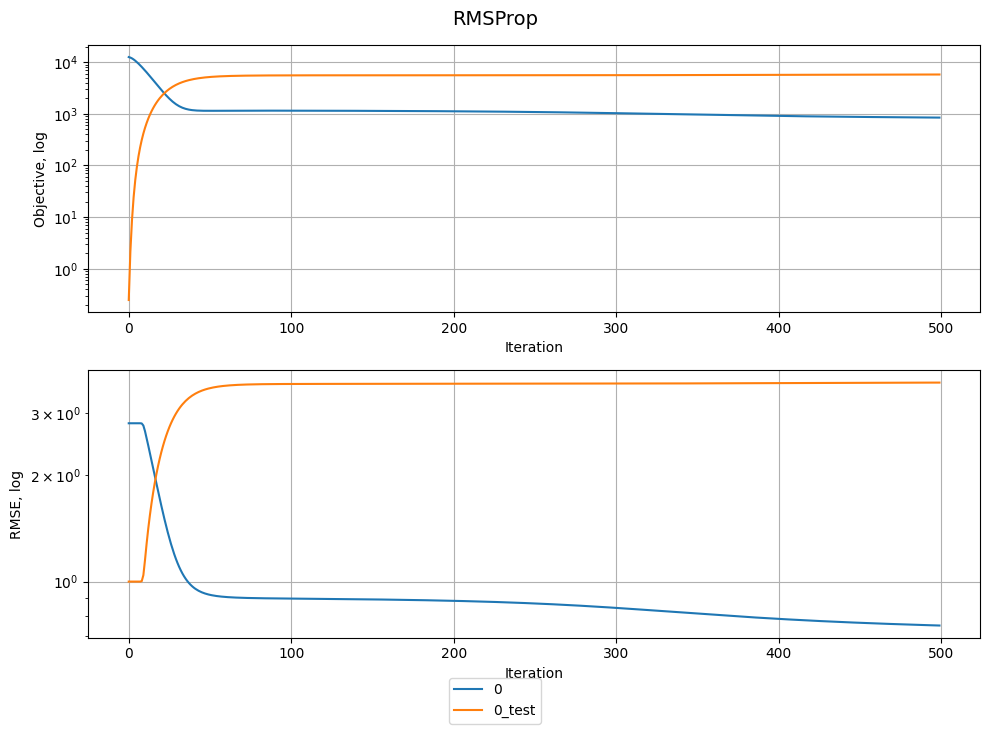

(tensor([[5.0000, 3.4498, 3.2274,  ..., 4.1927, 3.5288, 3.9888],
         [4.2703, 3.4253, 3.2567,  ..., 4.3202, 3.9002, 3.8647],
         [3.9040, 3.5322, 3.7221,  ..., 4.2526, 5.0000, 4.0841],
         ...,
         [3.3296, 2.8649, 2.6476,  ..., 3.5210, 5.0000, 3.9541],
         [3.9038, 3.1277, 2.8111,  ..., 3.6918, 4.5938, 4.0182],
         [3.0000, 2.2566, 1.5161,  ..., 2.6281, 4.6619, 3.5856]],
        device='cuda:0'),
 0.750562310218811,
 {'rank': 10,
  'iterations': 500,
  'init_strategy': 'mean',
  'verbose': True,
  'optimizer': __main__.RMSprop,
  'regularization': 0,
  'clip': False,
  'lr': 0.005,
  'lr_strategy': 'normal'})

In [ ]:
rms_res = choose_best(
    real_matrix,
    real_mask,
    real_test_mask,
    block_gd,
    {
        "rank": 10,
        "iterations": 500,
        "init_strategy": "mean",
        "verbose": True,
        "optimizer": RMSprop,
        "regularization": 0,
        "clip": False,
        "lr": 5e-3,
        "lr_strategy": "normal",
    },
)

plot_log_dicts(rms_res[-1], "RMSProp")

rms_res[:-1]

In [255]:
# save_solution(rms_res[0], decimals=5, prefix="rms_")

## Heuristic


In [ ]:
# def clamp_to_mean(
#     result: torch.Tensor, matrix: torch.Tensor, mask: torch.Tensor
# ) -> torch.Tensor:
#     x = result.clone()

#     means = torch.sum(matrix, axis=0) / torch.sum(mask, axis=0)

#     for j, m in zip(range(x.shape[1]), means):
#         lower = torch.where(x[:, j] > m)[0]
#         upper = torch.where(x[:, j] <= m)[0]
#         x[lower, j] = torch.floor(x[lower, j]).float()
#         x[upper, j] = torch.ceil(x[upper, j]).float()

#     return matrix + (~mask) * x



In [257]:
# mean_res = clamp_to_mean(gd_res[0], real_matrix, real_mask)

In [258]:
# save_solution(mean_res, decimals=0, prefix="gdeur")

In [259]:
# save_solution(torch.round(gd_res[0]), decimals=0, prefix="gderound")